1. Make sure that b-splines are correct
    x. Check the code for obvious errors
    2. Write energy function that works with b-splines
    3. Check if the TPF and B-spline energies are the same
2. Write LinReg optimization function
3. Fit energy to an existing potential (e.g., Marinica)
4. Write Backfitting optimization function
5. Optimize stat. distance

In [7]:
%matplotlib inline
import os
import sys
import re
import numpy as np
import pickle
from scipy.optimize import fmin
import multiprocessing as mp
import functools
import matplotlib.pyplot as plt

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, tpf_to_bsplines
from statmechlib.preprocessing import Trajectory, scale_configuration, pair_dist_cutoff, find_index
from statmechlib.read_write import params_to_pickle

In [4]:
working = '../data/working'

In [5]:
stats_file = 'stats_bs_samples' # 'stats_samples'

In [13]:
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi)

In [14]:
print(stats_tpf['hyperparams'])

{u'pair': [1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25, 5.35, 5.45, 5.55, 5.65, 5.75, 5.8500000000000005, 5.95], u'edens': [1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25, 5.35, 5.45, 5.55, 5.65, 5.75, 5.8500000000000005, 5.95]}


In [15]:
print(tpf_to_bsplines.__doc__)


    Convert statistics data from the cubic truncated power function (TPF) basis to b-splines.
    Only works for the special case of evenly separated knots. 

    Parameters
    ----------
    stats_tpf: dict
               Trajectory statistics information using TPF basis
               Should be based on evenly spaced knots with the last three
               being the boundary knots

    Returns
    -------
    stats_bspline: dict
               Trajectory statistics information using b-spline basis

    


In [16]:
np.linspace(1.05, 5.95, 50)

array([1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05,
       2.15, 2.25, 2.35, 2.45, 2.55, 2.65, 2.75, 2.85, 2.95, 3.05, 3.15,
       3.25, 3.35, 3.45, 3.55, 3.65, 3.75, 3.85, 3.95, 4.05, 4.15, 4.25,
       4.35, 4.45, 4.55, 4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25, 5.35,
       5.45, 5.55, 5.65, 5.75, 5.85, 5.95])

In [17]:
stats_tpf.keys()

[u'function',
 'bcc_npt_langevin_3700K',
 'vac_npt_langevin_2000K',
 'inf',
 'relax',
 'screw_111_npt_langevin_2000K',
 u'hyperparams',
 'bcc_npt_langevin_300K',
 'eos_bcc',
 'eos',
 'fcc_npt_langevin_300K',
 'vacint',
 'eos_fcc',
 'i110_npt_langevin_2000K',
 'liq_3700K',
 'liq_5000K',
 'i111_npt_langevin_2000K',
 'bain']

In [18]:
stats_bspline = tpf_to_bsplines(stats_tpf)

len 50


(1.95, 5.95)

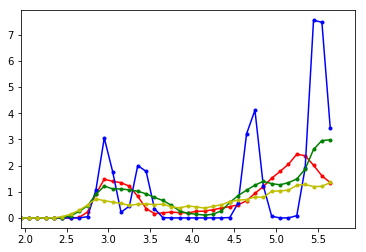

In [51]:
plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-4-3])+0.4, stats_bspline['fcc_npt_langevin_300K']['energy'][0][2][:-3], 'r.-')
plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-4-3])+0.4, stats_bspline['bcc_npt_langevin_300K']['energy'][0][2][:-3], 'b.-')
plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-4-3])+0.4, stats_bspline['bcc_npt_langevin_3700K']['energy'][0][2][:-3], 'g.-')
plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-4-3])+0.4, stats_bspline['liq_3700K']['energy'][0][2][:-3], 'y.-')

plt.xlim(1.95,5.95)


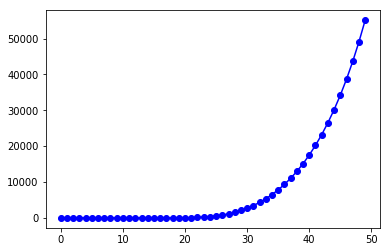

In [52]:
plt.plot(stats_tpf['relax']['energy'][0][2], 'bo-')

In [53]:
len(stats_bspline['hyperparams']['pair'][:-5]), len(stats_bspline['hyperparams']['pair'])

(45, 50)

In [55]:
target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    target = pickle.load(fi)

In [60]:
set(stats_bspline.keys()).difference(set(target.keys()))

{'function', 'hyperparams'}

In [58]:
stats_bspline.keys()

['function',
 'bcc_npt_langevin_3700K',
 'vac_npt_langevin_2000K',
 'relax',
 'screw_111_npt_langevin_2000K',
 'hyperparams',
 'i110_npt_langevin_2000K',
 'bcc_npt_langevin_300K',
 'i111_npt_langevin_2000K',
 'eos',
 'fcc_npt_langevin_300K',
 'vacint',
 'eos_fcc',
 'inf',
 'liq_3700K',
 'liq_5000K',
 'eos_bcc',
 'bain']

In [64]:
def make_matrices(target, stats):
    """
    Creates input data for energy minimization with target as dependent variable and stats as independent.
    Assumes that all appropriate knots from stats have been selected, so it includes everything.
    """
    
    # matrix of independent variables (Embedding and B-spline coefficients)
    X = []
    # vector of dependent variable (configurational energies)
    y = []
    
    for key in target:
        for config, energy in zip(stats[key]['energy'], target[key]['energy']):
            # add energy
            y.append(energy)
            
            # create an array of independent variables
            x_vars = [config[0][0], config[1][0]] # embedding
            x_vars += config[2]                   # pair interaction b-spline stats
            X.append()
    
    return X, y